# Proyecto Fundamentos Ciencia de Datos (Machine Learning)

Este cuaderno implementa la **Parte 5. Machine Learning** sobre el dataset de *Books to Scrape*,
 (modelos y métricas: `KNeighborsClassifier`, `LogisticRegression`, `SVC`, `LinearRegression`, `Ridge`; métricas `accuracy_score`, `classification_report`, `confusion_matrix`, `mean_absolute_error`, `mean_squared_error`).

**Preguntas de negocio** definidas para este dataset:

- **Predicción (Regresión):** *¿Cuál será el precio (sin impuestos) de un libro en función de su rating, disponibilidad y categoría?*
- **Clasificación (Binaria):** *¿Un libro será **caro** (precio por encima de la mediana) o será **no caro**?*

**Resumen de lo que hace el cuaderno:**
1. Carga y preparación del dataset (limpieza mínima, selección de variables).
2. División en **train/test** (20% test, `random_state=42`).
3. Entrenamiento de **cinco modelos**:
   - **Clasificación (3):** `LogisticRegression`, `SVC`, `KNeighborsClassifier`.
   - **Regresión (2):** `LinearRegression`, `Ridge`.
4. **Evaluación** con métricas usadas en tus tareas/actividades:
   - Clasificación: `accuracy_score`, `classification_report`, `confusion_matrix`.
   - Regresión: `mean_absolute_error`, `mean_squared_error` (y `RMSE` derivado).
5. **Comparación y selección** del mejor modelo por tarea (accuracy para clasificación; RMSE para regresión).


In [ ]:
# === Carga de datos ===
import os
import pandas as pd

DATA_PATH = "dfEncoding.csv"
if not os.path.exists(DATA_PATH):
    # Ruta alternativa (por si se ejecuta en otro entorno)
    alt = "/mnt/data/dfEncoding.csv"
    if os.path.exists(alt):
        DATA_PATH = alt

df = pd.read_csv(DATA_PATH)  # carga de datos
print("Shape:", df.shape)
df.head(3)


Shape: (1000, 58)


,Name,UPC,Price (excl. tax),Rating,Has Description,Image URL,Description,Availability,Category_Academic,Category_Add a comment,...,Category_Self Help,Category_Sequential Art,Category_Short Stories,Category_Spirituality,Category_Sports and Games,Category_Suspense,Category_Thriller,Category_Travel,Category_Womens Fiction,Category_Young Adult
0,A Light in the Attic,a897fe39b1053632,51.77,3,True,https://books.toscrape.com/media/cache/fe/72/f...,NaN,22,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Tipping the Velvet,90fa61229261140a,53.74,1,True,https://books.toscrape.com/media/cache/08/e9/0...,NaN,20,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Soumission,6957f44c3847a760,50.10,1,True,https://books.toscrape.com/media/cache/ee/cf/e...,NaN,20,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# --- Preparación/encoding ---

# Columnas presentes (para referencia):
df.columns.tolist()

# Variables objetivo
price_col = "Price (excl. tax)"
if price_col not in df.columns:
    raise ValueError(f"No se encuentra la columna esperada de precio: {price_col}")

# Binaria: caro si precio > mediana
import numpy as np
price_median = float(df[price_col].median())
df['is_expensive'] = (df[price_col] > price_median).astype(int)

# Selección de features candidatas (excluir campos de texto/ids/urls que no ayudan o fugan info)
exclude = {'Name', 'UPC', 'Image URL', 'Description'}
feature_cols = [c for c in df.columns
                if c not in exclude and c != price_col and c != 'is_expensive']

# Mantener numéricas/booleanas (sklearn maneja bools)
X = df[feature_cols].copy()

# Eliminamos columnas no numéricas si quedara alguna
num_cols = X.select_dtypes(include=['number', 'bool']).columns.tolist()
X = X[num_cols].astype(float)

# Objetivos
y_reg = df[price_col].astype(float)
y_clf = df['is_expensive'].astype(int)

print("Features usadas:", len(num_cols))
print("Ejemplo de columnas:", num_cols[:10])
print("Mediana de precio:", price_median)


Features usadas: 53
Ejemplo de columnas: ['Rating', 'Has Description', 'Availability', 'Category_Academic', 'Category_Add a comment', 'Category_Adult Fiction', 'Category_Art', 'Category_Autobiography', 'Category_Biography', 'Category_Business']
Mediana de precio: 35.980000000000004


In [ ]:
# === Train/Test split (20% test) ===
from sklearn.model_selection import train_test_split

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(  # train/test split
    X, y_reg, test_size=0.2, random_state=42, stratify=None
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(  # train/test split
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf  # estratificamos para balance binario
)

print("Regresión -> Train:", X_train_reg.shape, "Test:", X_test_reg.shape)
print("Clasificación -> Train:", X_train_clf.shape, "Test:", X_test_clf.shape)


Regresión -> Train: (800, 53) Test: (200, 53)
Clasificación -> Train: (800, 53) Test: (200, 53)


In [ ]:
# --- Modelos de clasificación ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

clf_results = {}

# 1) Logistic Regression
log_clf = LogisticRegression(max_iter=2000)  # modelo: Regresión Logística
log_clf.fit(X_train_clf, y_train_clf)
pred_log = log_clf.predict(X_test_clf)
acc_log = accuracy_score(y_test_clf, pred_log)  # métrica: accuracy
clf_results['LogisticRegression'] = {'accuracy': acc_log,
                                     'report': classification_report(y_test_clf, pred_log, zero_division=0),  # reporte de clasificación
                                     'cm': confusion_matrix(y_test_clf, pred_log)}  # matriz de confusión

# 2) SVC (sin escalado, replicando práctica)
svc_clf = SVC()  # modelo: SVM (clasificación)
svc_clf.fit(X_train_clf, y_train_clf)
pred_svc = svc_clf.predict(X_test_clf)
acc_svc = accuracy_score(y_test_clf, pred_svc)  # métrica: accuracy
clf_results['SVC'] = {'accuracy': acc_svc,
                      'report': classification_report(y_test_clf, pred_svc, zero_division=0),  # reporte de clasificación
                      'cm': confusion_matrix(y_test_clf, pred_svc)}  # matriz de confusión

# 3) KNN (k=5 por defecto habitual en clase)
knn_clf = KNeighborsClassifier(n_neighbors=5)  # modelo k-NN
knn_clf.fit(X_train_clf, y_train_clf)
pred_knn = knn_clf.predict(X_test_clf)
acc_knn = accuracy_score(y_test_clf, pred_knn)  # métrica: accuracy
clf_results['KNeighborsClassifier'] = {'accuracy': acc_knn,
                                       'report': classification_report(y_test_clf, pred_knn, zero_division=0),  # reporte de clasificación
                                       'cm': confusion_matrix(y_test_clf, pred_knn)}  # matriz de confusión

# Mostrar resultados
for name, res in clf_results.items():
    print(f"\n=== {name} ===")
    print("Accuracy:", round(res['accuracy'], 4))
    print("Confusion matrix:\n", res['cm'])
    print("Classification report:\n", res['report'])



=== LogisticRegression ===
Accuracy: 0.5
Confusion matrix:
 [[40 60]
 [40 60]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44       100
           1       0.50      0.60      0.55       100

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.50      0.50      0.49       200


=== SVC ===
Accuracy: 0.53
Confusion matrix:
 [[57 43]
 [51 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.57      0.55       100
           1       0.53      0.49      0.51       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200


=== KNeighborsClassifier ===
Accuracy: 0.47
Confusion matrix:
 [[43 57]
 [49 51]]
Classification report:
               precision    recall  f1-score  

In [ ]:
# --- Modelos de regresión ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import numpy as np

reg_results = {}

# 4) Linear Regression
lin_reg = LinearRegression()  # modelo: Regresión Lineal
lin_reg.fit(X_train_reg, y_train_reg)
pred_lin = lin_reg.predict(X_test_reg)
mae_lin = mean_absolute_error(y_test_reg, pred_lin)  # métrica: MAE
mse_lin = mean_squared_error(y_test_reg, pred_lin)  # métrica: MSE
rmse_lin = np.sqrt(mse_lin)
reg_results['LinearRegression'] = {'MAE': mae_lin, 'MSE': mse_lin, 'RMSE': rmse_lin}

# 5) Ridge
ridge_reg = Ridge(alpha=1.0, random_state=42)  # modelo: Ridge
ridge_reg.fit(X_train_reg, y_train_reg)
pred_ridge = ridge_reg.predict(X_test_reg)
mae_ridge = mean_absolute_error(y_test_reg, pred_ridge)  # métrica: MAE
mse_ridge = mean_squared_error(y_test_reg, pred_ridge)  # métrica: MSE
rmse_ridge = np.sqrt(mse_ridge)
reg_results['Ridge'] = {'MAE': mae_ridge, 'MSE': mse_ridge, 'RMSE': rmse_ridge}

for name, res in reg_results.items():
    print(f"\n=== {name} ===")
    print({k: round(v, 4) for k, v in res.items()})



=== LinearRegression ===
{'MAE': 12.9213, 'MSE': 225.569, 'RMSE': np.float64(15.019)}

=== Ridge ===
{'MAE': 12.8732, 'MSE': 222.5543, 'RMSE': np.float64(14.9183)}


In [ ]:

# --- Comparación y selección del mejor modelo ---
clf_df = pd.DataFrame({name: {'accuracy': res['accuracy']} for name, res in clf_results.items()}).T.sort_values('accuracy', ascending=False)  # tabla de accuracy por modelo (clasificación)  # ordenar descendente: mejor accuracy arriba
reg_df = pd.DataFrame(reg_results).T.sort_values('RMSE', ascending=True)  # tabla de RMSE por modelo (regresión)  # ordenar ascendente: menor RMSE es mejor

print("\nResumen clasificación (ordenado por Accuracy):\n", clf_df)  # mostrar ranking de clasificación
print("\nResumen regresión (ordenado por RMSE):\n", reg_df)  # mostrar ranking de regresión

best_clf = clf_df.index[0]  # tomar el nombre del modelo con mejor accuracy
best_reg = reg_df.index[0]  # tomar el nombre del modelo con menor RMSE

print(f"\nMejor modelo de CLASIFICACIÓN: {best_clf} (accuracy={clf_df.loc[best_clf, 'accuracy']:.4f})")  # reporte del mejor clasificador con su accuracy
print(f"Mejor modelo de REGRESIÓN: {best_reg} (RMSE={reg_df.loc[best_reg, 'RMSE']:.4f})")  # reporte del mejor regresor con su RMSE



Resumen clasificación (ordenado por Accuracy):
                       accuracy
SVC                       0.53
LogisticRegression        0.50
KNeighborsClassifier      0.47

Resumen regresión (ordenado por RMSE):
                         MAE         MSE       RMSE
Ridge             12.873183  222.554294  14.918254
LinearRegression  12.921337  225.568969  15.018954

Mejor modelo de CLASIFICACIÓN: SVC (accuracy=0.5300)
Mejor modelo de REGRESIÓN: Ridge (RMSE=14.9183)


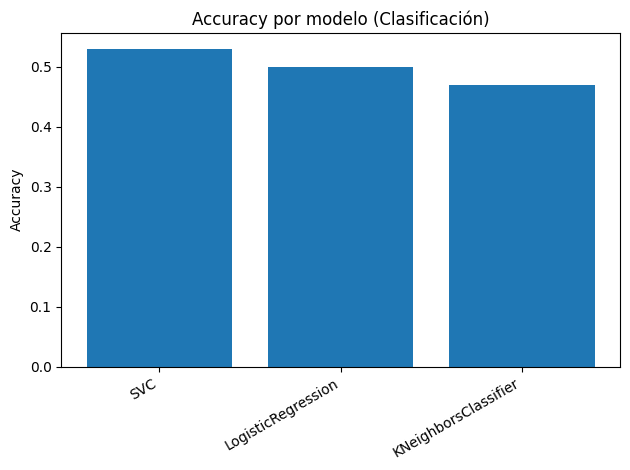

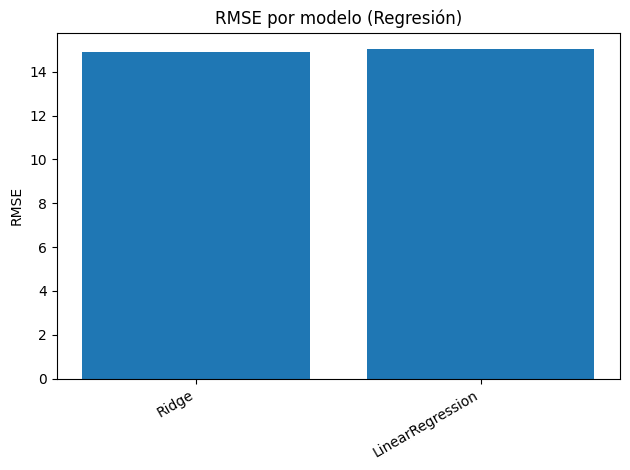

In [ ]:

# === Visualizaciones simples (matplotlib sin estilos/colores) ===
import matplotlib.pyplot as plt

# Clasificación: accuracy por modelo
plt.figure()
plt.bar(clf_df.index, clf_df['accuracy'])
plt.title("Accuracy por modelo (Clasificación)")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Regresión: RMSE por modelo
plt.figure()
plt.bar(reg_df.index, reg_df['RMSE'])
plt.title("RMSE por modelo (Regresión)")
plt.ylabel("RMSE")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
